<a href="https://colab.research.google.com/github/ANIZAI/Machine-Learning-based-Anomaly-Detection/blob/main/Prophet_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as pyplot
import altair as alt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pandas import datetime
from tqdm import tqdm
import plotly.graph_objects as go

%matplotlib inline
from fbprophet import Prophet

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [ ]:
pip install sklearn

In [ ]:
#def parser(x):
#	return datetime.strptime(x, '%d-%m-%Y %H:%M')

#speed_df = pd.read_csv('/content/Battery.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser, error_bad_lines=False)
#print(speed_df.head())
#speed_df.plot()

training_filename = '/content/BatteryTemp.csv'
train = pd.read_csv(training_filename, error_bad_lines='ignore')

valid_filename = '/content/test.csv'
test = pd.read_csv(valid_filename)
#pyplot.show()

In [ ]:
def parse_and_standardize(df: pd.DataFrame, scaler: StandardScaler = None):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['stand_value'] = df['value']
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(df['stand_value'].values.reshape(-1, 1))
    df['stand_value'] = scaler.transform(df['stand_value'].values.reshape(-1, 1))
    return scaler

data_scaler = parse_and_standardize(train)
parse_and_standardize(test, data_scaler)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
train.head()

timestamp     value  stand_value
0 2004-02-13 13:02:00  3.306531    -0.092577
1 2004-02-13 13:07:00  3.306531    -0.092577
2 2004-02-13 13:12:00  2.994446    -0.223774
3 2004-02-13 13:17:00  2.932029    -0.250014
4 2004-02-13 13:22:00  2.911223    -0.258760

In [ ]:
train=train.set_index('timestamp').resample("H").mean()

In [ ]:
import plotly.express as px
fig = px.scatter(train.reset_index(), x='timestamp', y='value', title='Batery Temperature')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1, label="1y", step="year", stepmode="backward"),
                      dict(count=2, label="3y", step="year", stepmode="backward"),
                      dict(count=3, label="5y", step="year", stepmode="backward"),
                      dict(step="all")
        ])
    )
)
fig.show()

In [ ]:
df = train.reset_index()[['timestamp','value']].rename({"timestamp":'ds', 'value':'y'}, axis='columns')

In [ ]:
df.shape

(95712, 2)

In [ ]:
m = Prophet(changepoint_range=0.95)

In [ ]:
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
future = m.make_future_dataframe(periods=120, freq='H')
future.tail(180)

ds
95652 2014-12-01 12:00:00
95653 2014-12-01 13:00:00
95654 2014-12-01 14:00:00
95655 2014-12-01 15:00:00
95656 2014-12-01 16:00:00
...                   ...
95827 2014-12-08 19:00:00
95828 2014-12-08 20:00:00
95829 2014-12-08 21:00:00
95830 2014-12-08 22:00:00
95831 2014-12-08 23:00:00

[180 rows x 1 columns]

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
95827 2014-12-08 19:00:00  8.568713    6.039760   11.322150
95828 2014-12-08 20:00:00  8.568384    5.817334   11.127061
95829 2014-12-08 21:00:00  8.555180    6.077065   11.116485
95830 2014-12-08 22:00:00  8.536129    6.046829   11.216804
95831 2014-12-08 23:00:00  8.526784    5.917058   11.073801

In [ ]:
results=pd.concat([df.set_index('ds')['y'], forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]], axis=1)

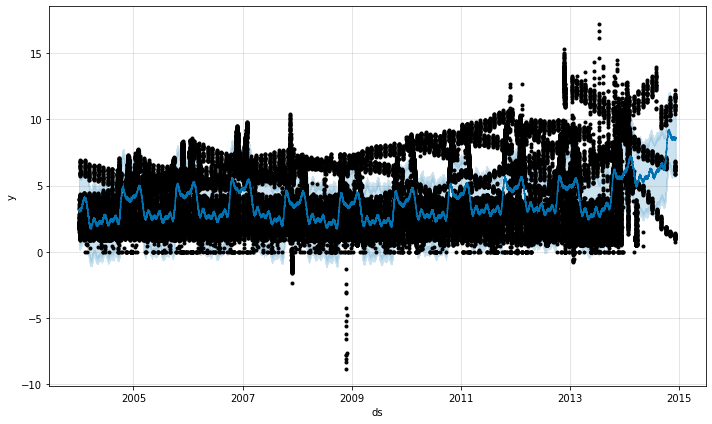

In [ ]:
fig1 = m.plot(forecast)

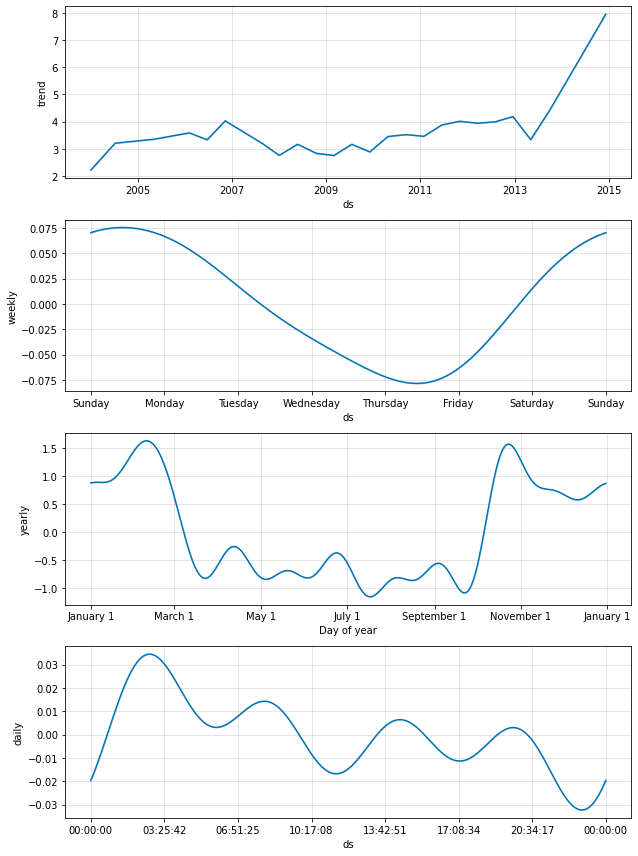

In [ ]:
comp=m.plot_components(forecast)

In [ ]:
results

y      yhat  yhat_lower  yhat_upper
ds                                                             
2004-01-03 00:00:00  1.949146  3.093490    0.402021    5.695138
2004-01-03 01:00:00  2.282600  3.123422    0.340764    5.864700
2004-01-03 02:00:00  2.036112  3.149588    0.595526    5.977454
2004-01-03 03:00:00  2.254487  3.158080    0.582444    5.804471
2004-01-03 04:00:00  2.109200  3.149979    0.588550    5.768372
...                       ...       ...         ...         ...
2014-12-08 19:00:00       NaN  8.568713    6.039760   11.322150
2014-12-08 20:00:00       NaN  8.568384    5.817334   11.127061
2014-12-08 21:00:00       NaN  8.555180    6.077065   11.116485
2014-12-08 22:00:00       NaN  8.536129    6.046829   11.216804
2014-12-08 23:00:00       NaN  8.526784    5.917058   11.073801

[95832 rows x 4 columns]

In [ ]:
results['error'] = results['y'] - results['yhat']

In [ ]:
results["uncertainty"] = results['yhat_upper'] - results['yhat_lower']

In [ ]:
results

y      yhat  ...     error  uncertainty
ds                                       ...                       
2004-01-03 00:00:00  1.949146  3.093490  ... -1.144343     5.293117
2004-01-03 01:00:00  2.282600  3.123422  ... -0.840821     5.523936
2004-01-03 02:00:00  2.036112  3.149588  ... -1.113476     5.381928
2004-01-03 03:00:00  2.254487  3.158080  ... -0.903593     5.222028
2004-01-03 04:00:00  2.109200  3.149979  ... -1.040779     5.179822
...                       ...       ...  ...       ...          ...
2014-12-08 19:00:00       NaN  8.568713  ...       NaN     5.282390
2014-12-08 20:00:00       NaN  8.568384  ...       NaN     5.309727
2014-12-08 21:00:00       NaN  8.555180  ...       NaN     5.039420
2014-12-08 22:00:00       NaN  8.536129  ...       NaN     5.169975
2014-12-08 23:00:00       NaN  8.526784  ...       NaN     5.156743

[95832 rows x 6 columns]

In [ ]:
results[results['error'].abs() > 1.5*results['uncertainty']]

y      yhat  ...      error  uncertainty
ds                                        ...                        
2008-11-26 07:00:00  -4.234421  3.498508  ...  -7.732928     4.956590
2008-11-26 08:00:00  -5.197766  3.501659  ...  -8.699425     4.989195
2008-11-26 09:00:00  -6.552651  3.494563  ... -10.047214     5.305115
2008-11-26 10:00:00  -6.239834  3.478807  ...  -9.718640     5.596274
2008-11-26 12:00:00  -5.595470  3.464417  ...  -9.059888     5.195642
...                        ...       ...  ...        ...          ...
2013-11-11 21:00:00  13.684150  5.617746  ...   8.066405     5.105073
2013-11-11 22:00:00  13.837488  5.598113  ...   8.239375     5.174436
2014-08-01 05:00:00  13.833170  6.001596  ...   7.831574     5.018170
2014-08-01 15:00:00  13.979807  6.041907  ...   7.937899     5.101708
2014-12-03 18:00:00   0.954115  8.480751  ...  -7.526636     5.000175

[285 rows x 6 columns]

In [ ]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis=1)

In [ ]:
results

y      yhat  ...  uncertainty  anomaly
ds                                       ...                      
2004-01-03 00:00:00  1.949146  3.093490  ...     5.293117       No
2004-01-03 01:00:00  2.282600  3.123422  ...     5.523936       No
2004-01-03 02:00:00  2.036112  3.149588  ...     5.381928       No
2004-01-03 03:00:00  2.254487  3.158080  ...     5.222028       No
2004-01-03 04:00:00  2.109200  3.149979  ...     5.179822       No
...                       ...       ...  ...          ...      ...
2014-12-08 19:00:00       NaN  8.568713  ...     5.282390       No
2014-12-08 20:00:00       NaN  8.568384  ...     5.309727       No
2014-12-08 21:00:00       NaN  8.555180  ...     5.039420       No
2014-12-08 22:00:00       NaN  8.536129  ...     5.169975       No
2014-12-08 23:00:00       NaN  8.526784  ...     5.156743       No

[95832 rows x 7 columns]

In [ ]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly', title='Battery Temperature')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1, label="1y", step="year", stepmode="backward"),
                      dict(count=2, label="3y", step="year", stepmode="backward"),
                      dict(count=3, label="5y", step="year", stepmode="backward"),
                      dict(step="all")
        ])
    )
)

fig.show()

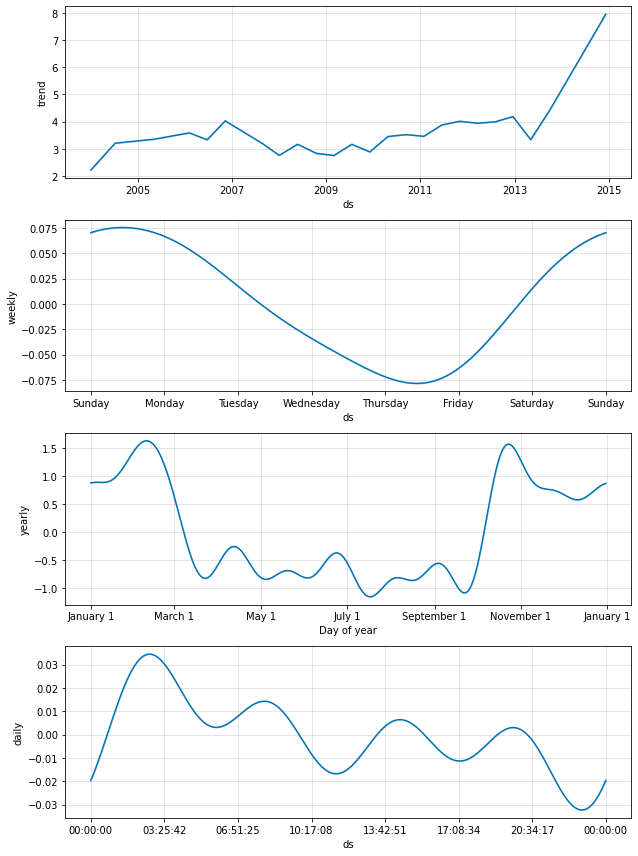

In [ ]:
comp = m.plot_components(forecast)

In [ ]:
results.dropna(inplace=True)

In [ ]:
results.tail()

y      yhat  ...  uncertainty  anomaly
ds                                       ...                      
2014-12-03 19:00:00  1.229296  8.487431  ...     5.187092       No
2014-12-03 20:00:00  0.955914  8.487789  ...     5.423653       No
2014-12-03 21:00:00  0.729765  8.475332  ...     5.390214       No
2014-12-03 22:00:00  1.061930  8.457090  ...     5.269909       No
2014-12-03 23:00:00  0.986490  8.448618  ...     5.154165       No

[5 rows x 7 columns]

In [ ]:
mean_squared_error(results.y, results.yhat)

4.225340031654838

In [ ]:
from math import sqrt
rms = sqrt(mean_squared_error(results.y, results.yhat))
print(rms)

2.055563190868828


In [ ]:
mean_absolute_error(results.y, results.yhat)

1.5613075146746966

In [ ]:
r2_score(results.y, results.yhat)

0.2261387258134